### Inception v3

In [19]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import time

In [2]:
image_dir = Path(r'/Users/rafay/Documents/FYP/abc')

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [4]:
abc = list(labels)

In [5]:
num_c = int(len(abc)/1000)

In [6]:
num_c

20

In [7]:
image_df['Label'].value_counts()

steak             100
pizza             100
apple_pie         100
burger            100
cup_cakes         100
french_fries      100
club_sandwich     100
cheesecake        100
french_toast      100
samosa            100
baklava           100
ice_cream         100
fried_rice        100
soup              100
waffles           100
sushi             100
donuts            100
chocolate_cake    100
grilled_salmon    100
pancakes          100
Name: Label, dtype: int64

In [8]:
image_df['Label']

0                steak
1                pizza
2       grilled_salmon
3       chocolate_cake
4       grilled_salmon
             ...      
1995      french_fries
1996            burger
1997           baklava
1998         ice_cream
1999            burger
Name: Label, Length: 2000, dtype: object

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1120 validated image filenames belonging to 20 classes.
Found 280 validated image filenames belonging to 20 classes.
Found 600 validated image filenames belonging to 20 classes.


In [12]:
batch_size = 32
img_height = 228
img_width = 228
channels = 3
img_shape = (img_height, img_width, channels)

In [13]:
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

Metal device set to: Apple M1


2022-07-05 13:31:06.743391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-05 13:31:06.743702: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
x = pre_trained.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_c, activation='sigmoid')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 228, 228, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 113, 113, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 113, 113, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 113, 113, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [22]:
STEP_SIZE_TRAIN = train_images.n // train_images.batch_size
STEP_SIZE_VALID = val_images.n // val_images.batch_size

history = model.fit_generator(train_images,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_images,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 20,
                    verbose = 1)

Epoch 1/20


2022-07-05 13:36:43.956294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - ETA: 0s - loss: 2.5205 - accuracy: 0.2955

2022-07-05 13:36:51.920728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 11s 264ms/step - loss: 2.5205 - accuracy: 0.2955 - val_loss: 2.1072 - val_accuracy: 0.4297
Epoch 2/20
35/35 [==============================] - 9s 247ms/step - loss: 1.3404 - accuracy: 0.6009 - val_loss: 1.7067 - val_accuracy: 0.5430
Epoch 3/20
35/35 [==============================] - 9s 249ms/step - loss: 0.9474 - accuracy: 0.7196 - val_loss: 1.5107 - val_accuracy: 0.5664
Epoch 4/20
35/35 [==============================] - 9s 246ms/step - loss: 0.6501 - accuracy: 0.8339 - val_loss: 1.4505 - val_accuracy: 0.5586
Epoch 5/20
35/35 [==============================] - 9s 247ms/step - loss: 0.5219 - accuracy: 0.8598 - val_loss: 1.3754 - val_accuracy: 0.5820
Epoch 6/20
35/35 [==============================] - 9s 245ms/step - loss: 0.3727 - accuracy: 0.9098 - val_loss: 1.3646 - val_accuracy: 0.5977
Epoch 7/20
35/35 [==============================] - 9s 247ms/step - loss: 0.2757 - accuracy: 0.9411 - val_loss: 1.3419 - val_accuracy: 0.5938
Epoch 8/20
35/35

In [23]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 65.33%


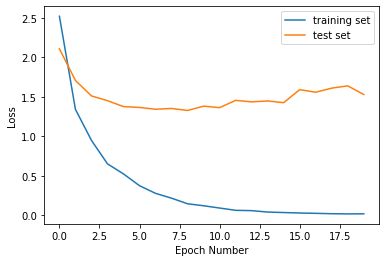

In [25]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

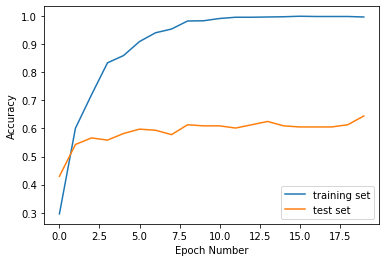

In [26]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [27]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, 
                            target_names=test_images.class_indices, 
                            zero_division=0)

2022-07-05 13:40:05.126797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


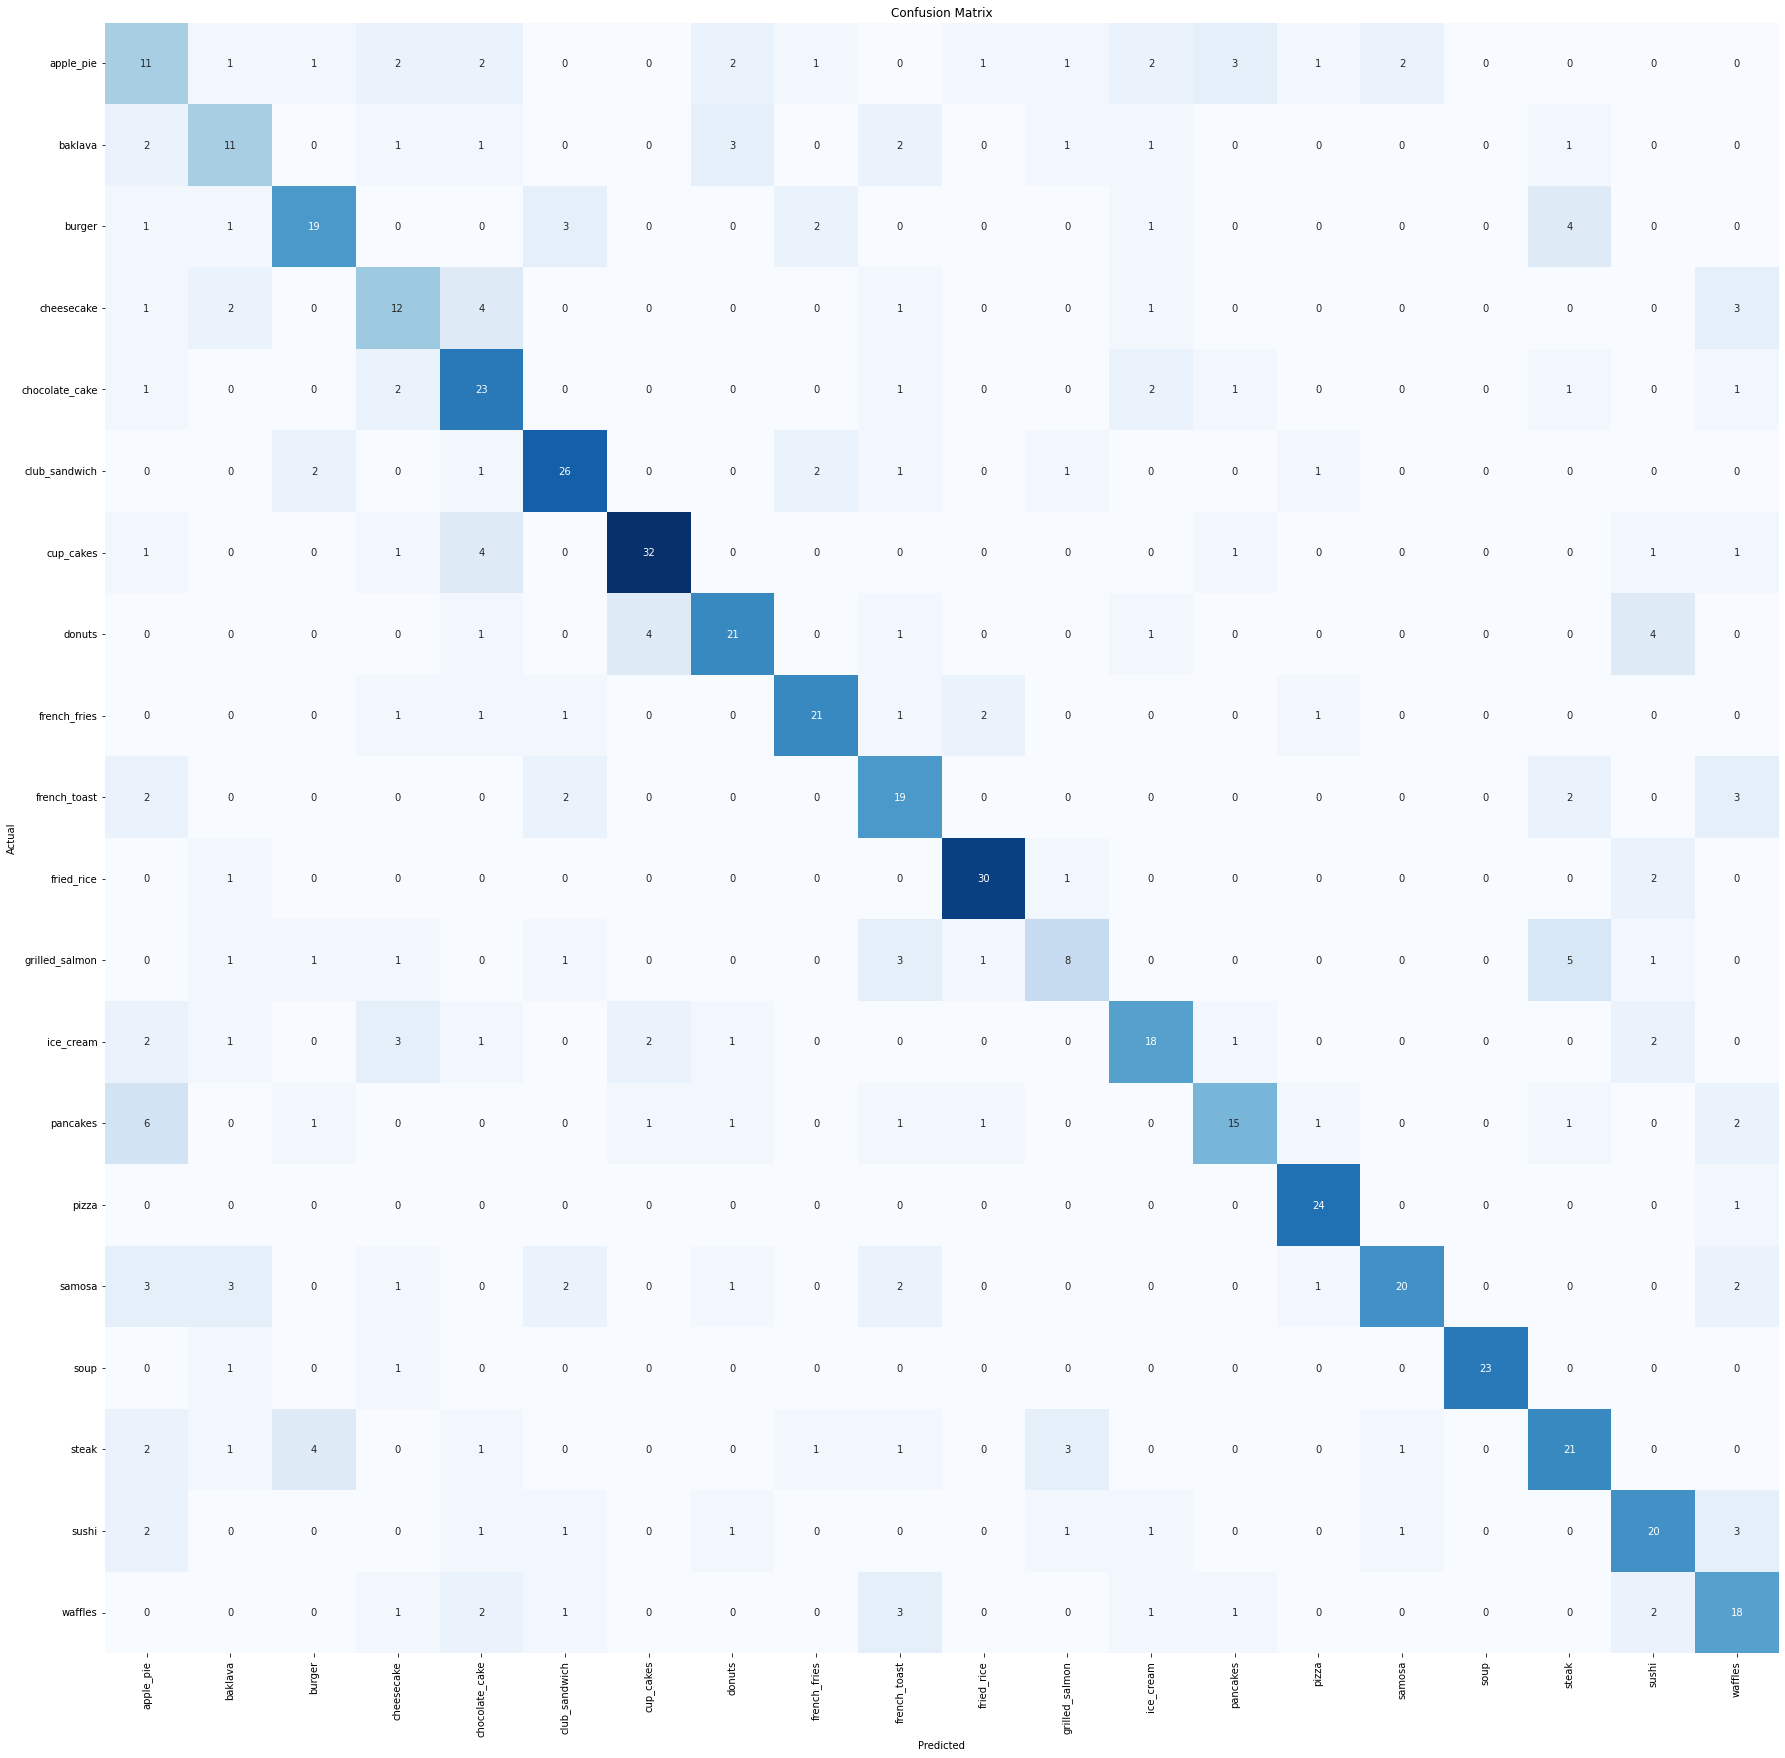

In [28]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(num_c) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(num_c) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
                 precision    recall  f1-score   support

     apple_pie       0.32      0.37      0.34        30
       baklava       0.48      0.48      0.48        23
        burger       0.68      0.61      0.64        31
    cheesecake       0.46      0.50      0.48        24
chocolate_cake       0.55      0.72      0.62        32
 club_sandwich       0.70      0.76      0.73        34
     cup_cakes       0.82      0.78      0.80        41
        donuts       0.70      0.66      0.68        32
  french_fries       0.78      0.75      0.76        28
  french_toast       0.53      0.68      0.59        28
    fried_rice       0.86      0.88      0.87        34
grilled_salmon       0.50      0.36      0.42        22
     ice_cream       0.64      0.58      0.61        31
      pancakes       0.68      0.50      0.58        30
         pizza       0.83      0.96      0.89        25
        samosa       0.83      0.57      0.68        35


In [30]:
model.save('gfgModel123.h5')

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

2022-07-05 13:40:58.349551: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/l2/njhk9drs1s9dq5m_mwdjpdc00000gn/T/tmp4u99mvdc/assets


2022-07-05 13:41:06.313915: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-05 13:41:06.314075: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-07-05 13:41:06.314633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-05 13:41:06.314650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-05 13:41:06.322428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-07-05 13:41:06.

In [32]:
with open('modelnew.tflite', 'wb') as f:
  f.write(tflite_model)